# NORMAL TESTING

In [1]:
pip install segmentation-models-pytorch albumentations opencv-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.2 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=055bd4

In [2]:
pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 16.4 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
train_image_dir="/kaggle/input/go-cricit-dataset/Assigment_dataset/train_mask/images"
train_mask_dir="/kaggle/input/go-cricit-dataset/Assigment_dataset/train_mask/mask"

valid_image_dir="/kaggle/input/go-cricit-dataset/Assigment_dataset/valid_mask/images"
valid_mask_dir="/kaggle/input/go-cricit-dataset/Assigment_dataset/valid_mask/mask"

In [4]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset,DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

        image_basenames = {os.path.splitext(f)[0] for f in image_files}
        mask_basenames = {os.path.splitext(f)[0] for f in mask_files}
        self.common_basenames = sorted(list(image_basenames & mask_basenames))

    def __len__(self):
        return len(self.common_basenames)

    def __getitem__(self, idx):
        basename = self.common_basenames[idx]
        img_path = os.path.join(self.image_dir, basename + '.jpg')
        mask_path = os.path.join(self.mask_dir, basename + '.png')

        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'))
        mask = (mask > 127).astype('float32')  # Binarize mask

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # Make mask shape [1, H, W]

        return image, mask


In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2(),
])


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
# Assuming you defined train_image_dir, train_mask_dir, valid_image_dir, valid_mask_dir
train_dataset = SegmentationDataset(train_image_dir, train_mask_dir, transform=train_transform)
val_dataset = SegmentationDataset(valid_image_dir, valid_mask_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [7]:

class SegmentationDataset(Dataset):
    def __getitem__(self, idx):
            img_path = os.path.join(self.image_dir, self.image_files[idx])
            mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
    
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")  # grayscale mask
    
            image = np.array(image)
            mask = np.array(mask)
    
            # Binarize the mask: convert any non-zero pixel to 1
            mask = (mask > 0).astype(np.uint8)
    
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
    
            return image, mask    
        
    def __init__(self, image_dir, mask_dir, transform=None):
            self.image_dir = image_dir
            self.mask_dir = mask_dir
            self.transform = transform
            self.image_files = sorted(os.listdir(image_dir))
            self.mask_files = [f.replace(".jpg", ".png") for f in self.image_files]

    def __len__(self):
        return len(self.image_files)

    


In [8]:
import torch
import torch.optim as optim
import segmentation_models_pytorch as smp
from torchmetrics.segmentation import DiceScore
from torch.utils.data import DataLoader

# Model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

# Loss and optimizer
loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize separate Dice metrics for training and validation
dice_metric_train = DiceScore(num_classes=1).to(device)
dice_metric_val = DiceScore(num_classes=1).to(device)

epochs = 15
for epoch in range(epochs):
    # --------- Training Phase ---------
    model.train()
    running_loss = 0.0
    dice_metric_train.reset()
    
    for images, masks in train_loader:
        images = images.to(device, dtype=torch.float)

        # Ensure masks are [B, 1, H, W]
        masks = masks.to(device)
        if masks.dim() == 3:
            masks = masks.unsqueeze(1)
        elif masks.dim() == 5:
            masks = masks.squeeze(2)
        
        masks = masks.float()

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Compute dice score for training batch
        preds = torch.sigmoid(outputs) > 0.5
        dice_metric_train.update(preds.int(), masks.int())
    
    avg_train_loss = running_loss / len(train_loader)
    train_dice = dice_metric_train.compute().item()

    # --------- Validation Phase ---------
    model.eval()
    val_loss = 0.0
    dice_metric_val.reset()
    
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device, dtype=torch.float)

            val_masks = val_masks.to(device)
            if val_masks.dim() == 3:
                val_masks = val_masks.unsqueeze(1)
            elif val_masks.dim() == 5:
                val_masks = val_masks.squeeze(2)

            val_masks = val_masks.float()
            
            val_outputs = model(val_images)
            loss = loss_fn(val_outputs, val_masks)
            val_loss += loss.item()
            
            val_preds = torch.sigmoid(val_outputs) > 0.5
            dice_metric_val.update(val_preds.int(), val_masks.int())
    
    avg_val_loss = val_loss / len(val_loader)
    val_dice = dice_metric_val.compute().item()

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"   Train Loss: {avg_train_loss:.4f}, Train Dice Score: {train_dice:.4f}")
    print(f"   Val Loss:   {avg_val_loss:.4f}, Val Dice Score:   {val_dice:.4f}")
    print("-" * 50)

# Save model
torch.save(model.state_dict(), 'unet_model.pth')


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 283MB/s]


Epoch [1/15]
   Train Loss: 0.9403, Train Dice Score: 0.0711
   Val Loss:   0.9261, Val Dice Score:   0.1080
--------------------------------------------------
Epoch [2/15]
   Train Loss: 0.9081, Train Dice Score: 0.1738
   Val Loss:   0.9100, Val Dice Score:   0.2053
--------------------------------------------------
Epoch [3/15]
   Train Loss: 0.8789, Train Dice Score: 0.2599
   Val Loss:   0.8755, Val Dice Score:   0.2963
--------------------------------------------------
Epoch [4/15]
   Train Loss: 0.8423, Train Dice Score: 0.3358
   Val Loss:   0.8554, Val Dice Score:   0.3120
--------------------------------------------------
Epoch [5/15]
   Train Loss: 0.7961, Train Dice Score: 0.3799
   Val Loss:   0.8283, Val Dice Score:   0.3103
--------------------------------------------------
Epoch [6/15]
   Train Loss: 0.7260, Train Dice Score: 0.4488
   Val Loss:   0.7820, Val Dice Score:   0.3226
--------------------------------------------------
Epoch [7/15]
   Train Loss: 0.6369, Trai

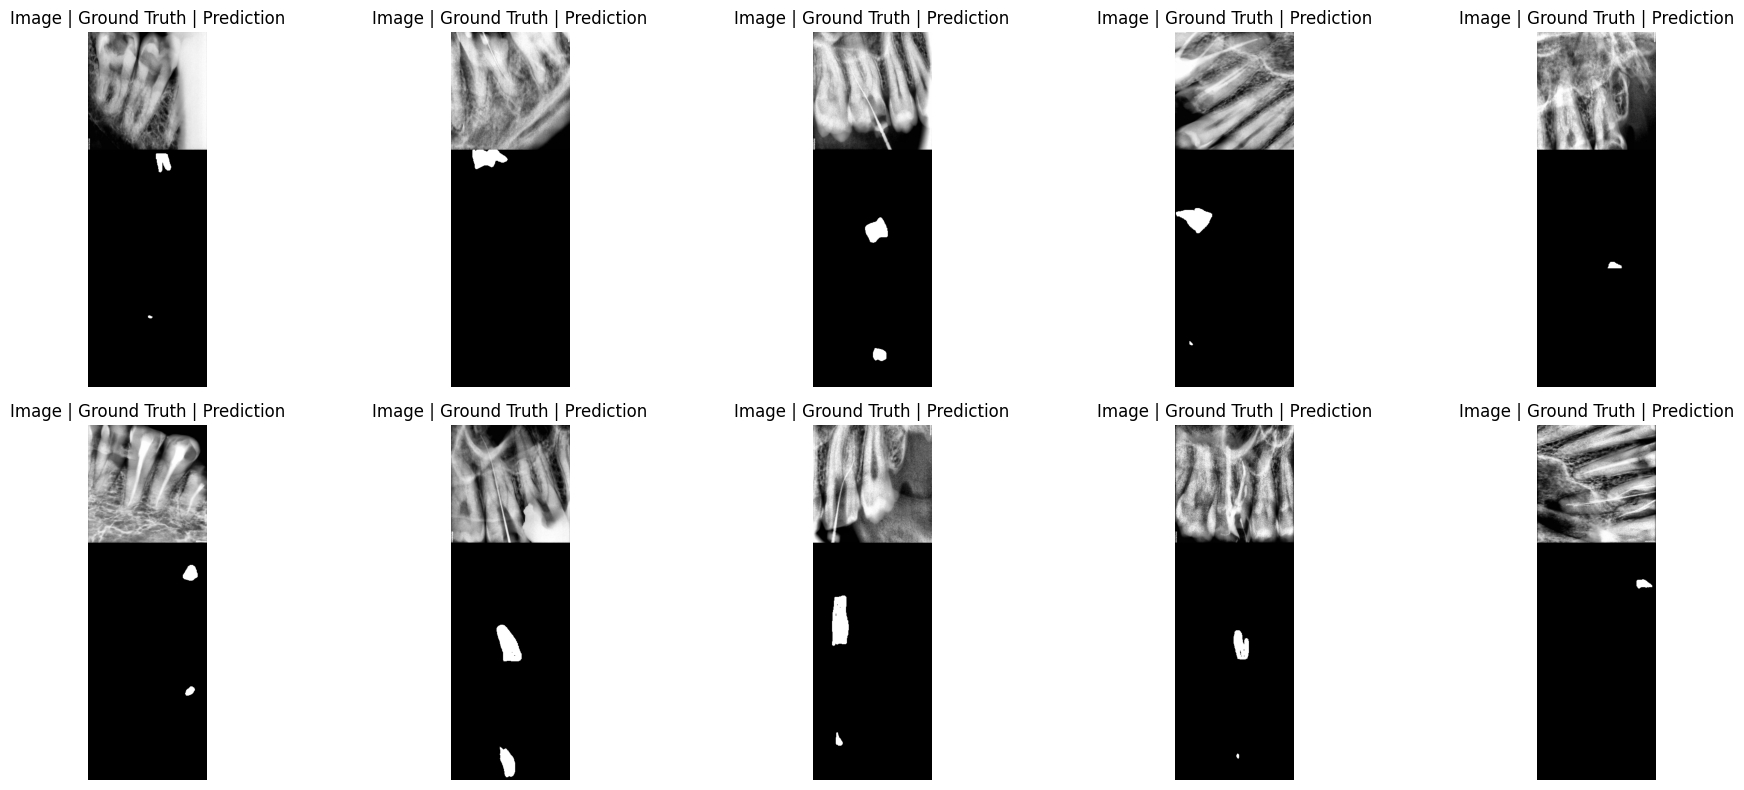

In [9]:
import random
import torch
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def show_random_predictions_grid(model, dataloader, num_samples=10):
    all_images = []
    all_masks = []
    
    # Collect all data from validation loader
    for images, masks in dataloader:
        for i in range(images.size(0)):
            all_images.append(images[i])
            all_masks.append(masks[i])
    
    # Randomly select indices
    indices = random.sample(range(len(all_images)), num_samples)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for ax, idx in zip(axes.flatten(), indices):
        image = all_images[idx].unsqueeze(0).to(device)
        mask = all_masks[idx].unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image)
            pred = torch.sigmoid(output)
            pred = (pred > 0.5).float()

        # Prepare visuals
        img_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
        true_mask_np = mask.squeeze().cpu().numpy()
        pred_mask_np = pred.squeeze().cpu().numpy()

        # Stack vertically for display
        combined = torch.cat([
            torch.tensor(img_np).permute(2, 0, 1)[:3],
            torch.tensor(true_mask_np).unsqueeze(0).repeat(3, 1, 1),
            torch.tensor(pred_mask_np).unsqueeze(0).repeat(3, 1, 1)
        ], dim=1).permute(1, 2, 0).numpy()

        ax.imshow(combined)
        ax.axis('off')
        ax.set_title("Image | Ground Truth | Prediction")

    plt.tight_layout()
    plt.show()

# Call the function
show_random_predictions_grid(model, val_loader, num_samples=10)


# DEEPLABV2 WITH RESNET

In [10]:
pip install segmentation-models-pytorch albumentations timm


Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = [f.replace(".jpg", ".png") for f in self.image_files]

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = np.array(image)
        mask = np.array(mask)
        mask = (mask > 0).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

    def __len__(self):
        return len(self.image_files)


In [12]:
import torch

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [13]:
from torch.utils.data import DataLoader, random_split

# Split dataset
full_dataset = SegmentationDataset(train_image_dir, train_mask_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Override val transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [14]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # Try "timm-efficientnet-b3" for better results
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,                      # Binary segmentation
    activation=None
).to("cuda")


In [15]:
import torch.nn as nn

loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def dice_score(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    smooth = 1e-6
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    return (2 * intersection + smooth) / (union + smooth)


In [16]:
num_epochs = 20
best_dice = 0

for epoch in range(num_epochs):
    model.train()
    train_loss, train_dice = 0, 0
    for images, masks in train_loader:
        images, masks = images.to("cuda"), masks.to("cuda").unsqueeze(1).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_dice += dice_score(outputs, masks).item()

    model.eval()
    val_dice = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to("cuda"), masks.to("cuda").unsqueeze(1).float()
            outputs = model(images)
            val_dice += dice_score(outputs, masks).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)
    avg_val_dice = val_dice / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}")

    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        torch.save(model.state_dict(), "best_deeplabv3plus.pth")


Epoch 1/20 - Loss: 0.9320, Train Dice: 0.1163, Val Dice: 0.1159
Epoch 2/20 - Loss: 0.8890, Train Dice: 0.1711, Val Dice: 0.1410
Epoch 3/20 - Loss: 0.8505, Train Dice: 0.2500, Val Dice: 0.2001
Epoch 4/20 - Loss: 0.8081, Train Dice: 0.3525, Val Dice: 0.2480
Epoch 5/20 - Loss: 0.7626, Train Dice: 0.4449, Val Dice: 0.3169
Epoch 6/20 - Loss: 0.7145, Train Dice: 0.5166, Val Dice: 0.2855
Epoch 7/20 - Loss: 0.6717, Train Dice: 0.5632, Val Dice: 0.2783
Epoch 8/20 - Loss: 0.6220, Train Dice: 0.5925, Val Dice: 0.2980
Epoch 9/20 - Loss: 0.5647, Train Dice: 0.6324, Val Dice: 0.3170
Epoch 10/20 - Loss: 0.5063, Train Dice: 0.6689, Val Dice: 0.3146
Epoch 11/20 - Loss: 0.4620, Train Dice: 0.6949, Val Dice: 0.3574
Epoch 12/20 - Loss: 0.4247, Train Dice: 0.7024, Val Dice: 0.3490
Epoch 13/20 - Loss: 0.3788, Train Dice: 0.7405, Val Dice: 0.3293
Epoch 14/20 - Loss: 0.3641, Train Dice: 0.7315, Val Dice: 0.3440
Epoch 15/20 - Loss: 0.3176, Train Dice: 0.7685, Val Dice: 0.3419
Epoch 16/20 - Loss: 0.3172, Train 

In [18]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_prediction(model, dataset, index, device='cuda'):
    model.eval()
    
    image, true_mask = dataset[index]
    input_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred_mask = model(input_tensor)
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask = (pred_mask > 0.5).float().cpu().squeeze().numpy()
    
    # Prepare data for plotting
    image_np = image.permute(1, 2, 0).cpu().numpy()
    true_mask_np = true_mask.cpu().numpy()
    
    # Undo normalization if applied
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)

    # Plot image, true mask, and predicted mask
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_np, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()


In [19]:
def visualize_predictions_grid(model, dataset, indices, device='cuda'):
    model.eval()
    num_images = len(indices)
    rows, cols = 2, 5
    assert num_images == rows * cols, f"Please provide exactly {rows * cols} indices for a 2x5 grid."

    fig, axes = plt.subplots(rows, cols, figsize=(20, 8))

    for ax, index in zip(axes.flatten(), indices):
        image, true_mask = dataset[index]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = model(input_tensor)
            pred_mask = torch.sigmoid(pred_mask)
            pred_mask = (pred_mask > 0.5).float().cpu().squeeze().numpy()

        # Prepare image and masks for display
        image_np = image.permute(1, 2, 0).cpu().numpy()
        true_mask_np = true_mask.cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)

        # Stack vertically: original | ground truth | prediction
        height, width = true_mask_np.shape
        combined_image = np.zeros((height * 3, width, 3))

        combined_image[0:height] = image_np
        combined_image[height:2*height, :, :] = np.stack([true_mask_np]*3, axis=-1)
        combined_image[2*height:3*height, :, :] = np.stack([pred_mask]*3, axis=-1)

        ax.imshow(combined_image)
        ax.set_title(f"Index: {index}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_31/379611140.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deeplabv3plus.pth"))


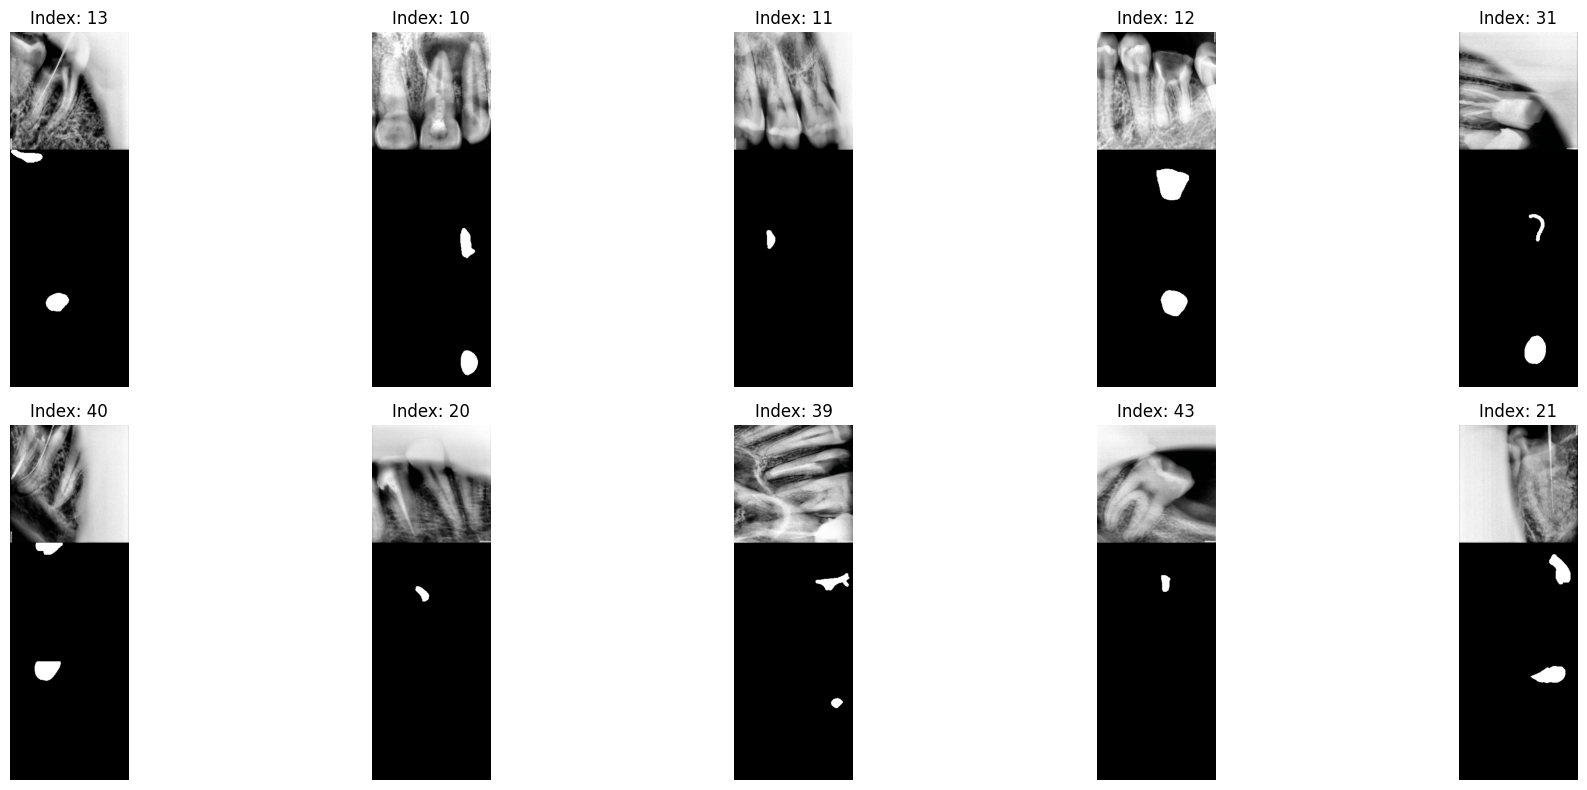

In [20]:
# Load best model
model.load_state_dict(torch.load("best_deeplabv3plus.pth"))
model.to("cuda")

indices = random.sample(range(len(val_dataset)), 10)
visualize_predictions_grid(model, val_dataset, indices, device='cuda')


# DEEPLABV2 WITH MITB5

In [21]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt


class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = [f.replace(".jpg", ".png") for f in self.image_files]

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = np.array(image)
        mask = np.array(mask)
        mask = (mask > 0).astype(np.uint8)  # binarize

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

    def __len__(self):
        return len(self.image_files)

In [22]:

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2, p=0.5),  # increased intensity
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

/tmp/ipykernel_31/671339353.py:9: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),


In [23]:

image_directory = train_image_dir
mask_directory  = train_mask_dir
full_dataset = SegmentationDataset(image_directory, mask_directory, transform=train_transform)


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [24]:

import segmentation_models_pytorch as smp
import torch

model = smp.DeepLabV3Plus(
    encoder_name="mit_b5",             
    encoder_weights="imagenet",        
    in_channels=3,
    classes=1,                        
    activation=None
).to("cuda")



dice_loss_fn = smp.losses.DiceLoss(mode='binary')
bce_loss_fn  = nn.BCEWithLogitsLoss()

def combined_loss(outputs, targets):
    return 0.6 * dice_loss_fn(outputs, targets) + 0.4 * bce_loss_fn(outputs, targets)

Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b5.pth" to /root/.cache/torch/hub/checkpoints/mit_b5.pth
100%|██████████| 313M/313M [00:02<00:00, 124MB/s]  


In [25]:
def dice_score(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    smooth = 1e-6
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    return (2 * intersection + smooth) / (union + smooth)


optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)


# Training Loop
num_epochs = 20 
best_val_dice = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_dice = 0
    
    for images, masks in train_loader:
        images = images.to("cuda")
        masks = masks.to("cuda").unsqueeze(1).float()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_dice += dice_score(outputs, masks).item()
    
    scheduler.step()
    
    model.eval()
    val_dice = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to("cuda")
            masks = masks.to("cuda").unsqueeze(1).float()
            outputs = model(images)
            val_dice += dice_score(outputs, masks).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)
    avg_val_dice   = val_dice / len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}")
    
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(model.state_dict(), "best_deeplabv3plus_improved.pth")


Epoch 1/20 - Loss: 0.7782, Train Dice: 0.1539, Val Dice: 0.2168
Epoch 2/20 - Loss: 0.7208, Train Dice: 0.2920, Val Dice: 0.2847
Epoch 3/20 - Loss: 0.6664, Train Dice: 0.3959, Val Dice: 0.3523
Epoch 4/20 - Loss: 0.6161, Train Dice: 0.4745, Val Dice: 0.2877
Epoch 5/20 - Loss: 0.5714, Train Dice: 0.5334, Val Dice: 0.3093
Epoch 6/20 - Loss: 0.5314, Train Dice: 0.6057, Val Dice: 0.3479
Epoch 7/20 - Loss: 0.4936, Train Dice: 0.6481, Val Dice: 0.3968
Epoch 8/20 - Loss: 0.4614, Train Dice: 0.6829, Val Dice: 0.3995
Epoch 9/20 - Loss: 0.4358, Train Dice: 0.6993, Val Dice: 0.3975
Epoch 10/20 - Loss: 0.4123, Train Dice: 0.7119, Val Dice: 0.4101
Epoch 11/20 - Loss: 0.3859, Train Dice: 0.7462, Val Dice: 0.3854
Epoch 12/20 - Loss: 0.3698, Train Dice: 0.7536, Val Dice: 0.3976
Epoch 13/20 - Loss: 0.3506, Train Dice: 0.7710, Val Dice: 0.4210
Epoch 14/20 - Loss: 0.3390, Train Dice: 0.7831, Val Dice: 0.4096
Epoch 15/20 - Loss: 0.3291, Train Dice: 0.7906, Val Dice: 0.4109
Epoch 16/20 - Loss: 0.3207, Train 

/tmp/ipykernel_31/3395383082.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deeplabv3plus_improved.pth"))


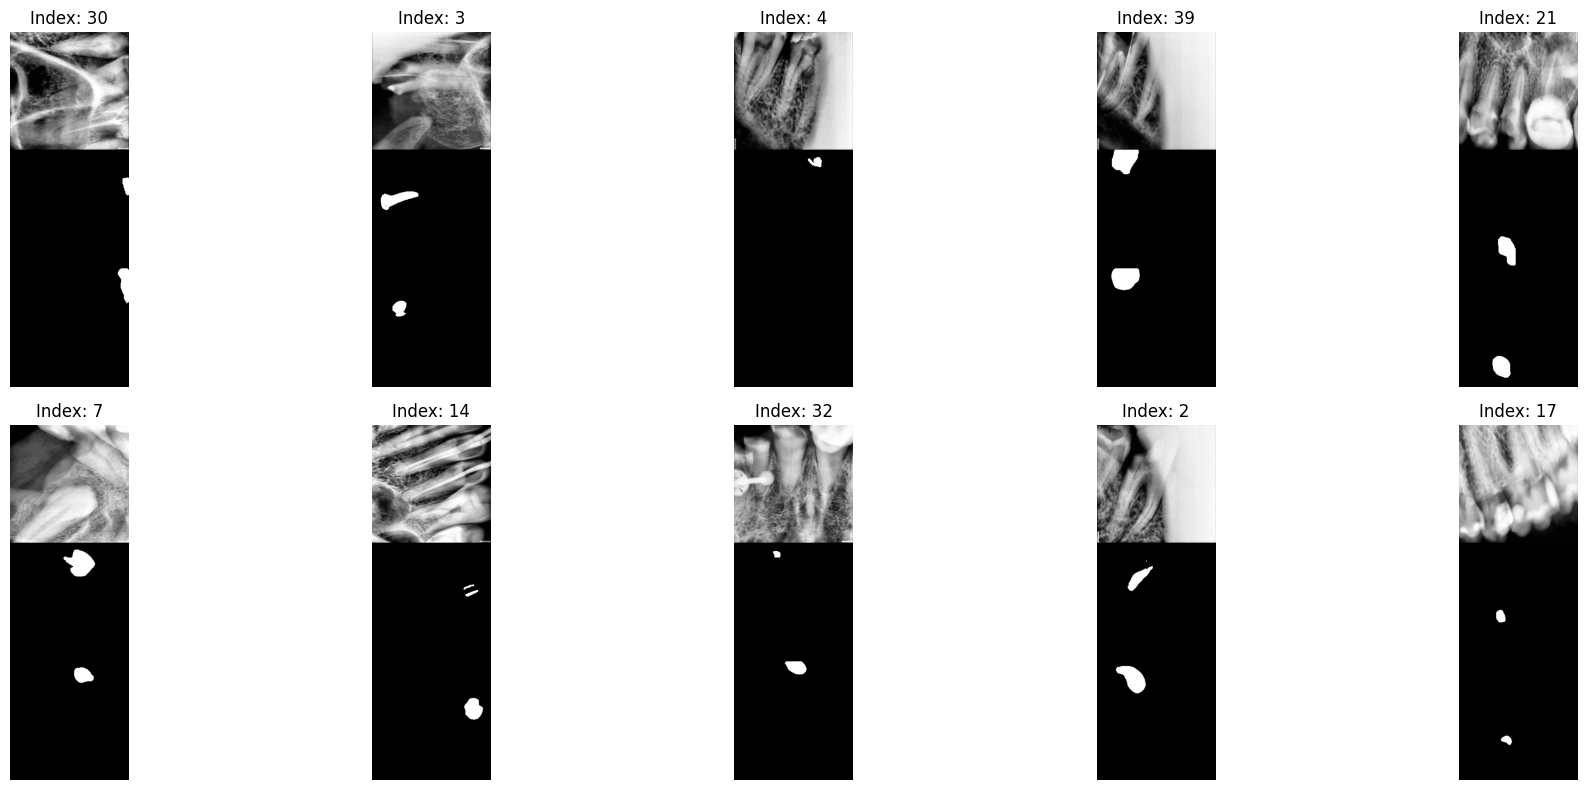

In [27]:
model.load_state_dict(torch.load("best_deeplabv3plus_improved.pth"))
model.to("cuda")

indices = random.sample(range(len(val_dataset)), 10)
visualize_predictions_grid(model, val_dataset, indices, device='cuda')


# DEEPLABV2+ WITH EARLY STOPPING

Epoch 1/20 [Training]: 100%|██████████| 22/22 [00:33<00:00,  1.53s/it, Loss=0.269]


Epoch 1/20 - Loss: 0.3160, Train Dice: 0.7972, Val Dice: 0.4214


Epoch 2/20 [Training]: 100%|██████████| 22/22 [00:33<00:00,  1.53s/it, Loss=0.367]


Epoch 2/20 - Loss: 0.3152, Train Dice: 0.7998, Val Dice: 0.4182


Epoch 3/20 [Training]: 100%|██████████| 22/22 [00:33<00:00,  1.53s/it, Loss=0.331]


Epoch 3/20 - Loss: 0.3148, Train Dice: 0.8075, Val Dice: 0.4074


Epoch 4/20 [Training]: 100%|██████████| 22/22 [00:33<00:00,  1.53s/it, Loss=0.294]


Epoch 4/20 - Loss: 0.3140, Train Dice: 0.8034, Val Dice: 0.4028


Epoch 5/20 [Training]: 100%|██████████| 22/22 [00:33<00:00,  1.53s/it, Loss=0.36] 


Epoch 5/20 - Loss: 0.3132, Train Dice: 0.8080, Val Dice: 0.4041


Epoch 6/20 [Training]: 100%|██████████| 22/22 [00:33<00:00,  1.54s/it, Loss=0.28] 


Epoch 6/20 - Loss: 0.3102, Train Dice: 0.8084, Val Dice: 0.4067
Early stopping triggered at epoch 6


/tmp/ipykernel_31/2932882110.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deeplabv3plus_improved.pth"))


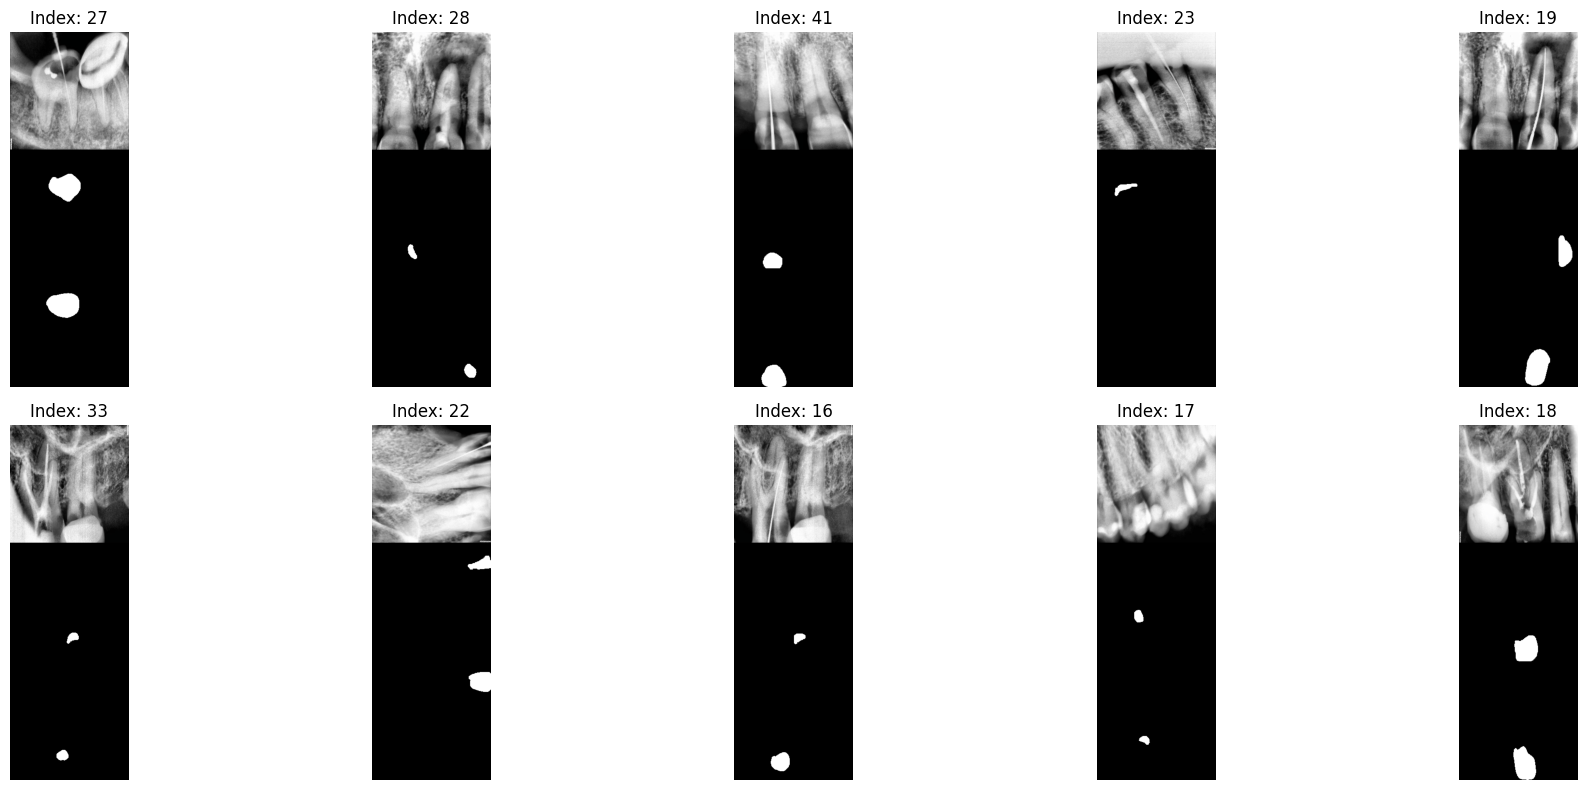

In [28]:
from tqdm import tqdm  


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True)

num_epochs = 20
best_val_dice = 0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_dice = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for images, masks in pbar:
        images = images.to("cuda", non_blocking=True)
        masks = masks.to("cuda", non_blocking=True).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_score(outputs, masks).item()
        pbar.set_postfix({"Loss": loss.item()})

    scheduler.step()

    model.eval()
    val_dice = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to("cuda", non_blocking=True)
            masks = masks.to("cuda", non_blocking=True).unsqueeze(1).float()
            outputs = model(images)
            val_dice += dice_score(outputs, masks).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)
    avg_val_dice   = val_dice / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}")

    # Early Stopping & Saving Best Model
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        patience_counter = 0
        torch.save(model.state_dict(), "best_deeplabv3plus_improved.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

model.load_state_dict(torch.load("best_deeplabv3plus_improved.pth"))
model.to("cuda")


indices = random.sample(range(len(val_dataset)), 10)
visualize_predictions_grid(model, val_dataset, indices, device='cuda')